<a href="https://colab.research.google.com/github/jeffersonlbsb/time_serie_w_pycaret/blob/main/prev_clos_google_tsfe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries temporais com Pycaret

Neste trabalho tenho como intuito fazer uma previsão de 12 mêses do fechamento da cota do Google na bolsa de valores, baseado apenas na série temporal do próprio fechamento.

O conjunto de dados vai de Janeiro de 2006 até Dezembro de 2017 e possui 7 variáveis, sendo que usaremos apenas duas delas.

Para acessar os dados utilizados clique [aqui](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231).

Toda a parte de modelagem será feita em uma nova ferramenta do Pycaret chamada TSForecastingExperiment, porém ainda é recente e ainda é um experimento.

Esta é a minha primeira vez utilizando esta ferramenta, portanto peço que desculpem qualquer erro cometido.

## Instalando o pycaret na máquina virtual

In [1]:
pip install pycaret-ts-alpha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importando as bibliotecas que serão utilizadas

In [11]:
import numpy as np # algebra
import pandas as pd # processamento e manipulação de dados
import seaborn as sns # graficos
import matplotlib.pyplot as plt # graficos
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # análise de auto correlação e auto correlação parcial
from statsmodels.tsa.seasonal import seasonal_decompose # para decomposição da serie
import warnings
warnings.filterwarnings("ignore") # para as mensagens de aviso não aparecerem no output
import statsmodels.api as sm # para plots
from statsmodels.tsa.stattools import adfuller # para conferir se há estacionariedade
from sktime.utils.plotting import plot_series # plot das previsões das series
from pycaret.time_series import * # para escolha e criação dos modelos

## Carregando o conjunto de dados

In [3]:
df = pd.read_csv('/content/GOOGL_2006-01-01_to_2018-01-01.csv')

Vamos dar uma olhada nas 10 primeiras e nas 10 últimas observações do nosso conjunto de dados.

In [4]:
df.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
5,2006-01-10,232.44,235.36,231.25,235.11,9104719,GOOGL
6,2006-01-11,235.87,237.79,234.82,236.05,9008664,GOOGL
7,2006-01-12,237.10,237.73,230.98,232.05,10125212,GOOGL
8,2006-01-13,232.39,233.68,231.04,233.36,7660220,GOOGL
9,2006-01-17,231.76,235.18,231.50,233.79,8335300,GOOGL


In [5]:
df.tail(10)

,Date,Open,High,Low,Close,Volume,Name
3009,2017-12-15,1063.78,1075.25,1060.09,1072.00,3187985,GOOGL
3010,2017-12-18,1076.45,1086.49,1070.37,1085.09,1514601,GOOGL
3011,2017-12-19,1083.02,1084.98,1072.27,1079.78,1317519,GOOGL
3012,2017-12-20,1080.92,1081.24,1068.60,1073.56,1436391,GOOGL
3013,2017-12-21,1075.39,1077.52,1069.00,1070.85,1282025,GOOGL
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL
3018,2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,GOOGL


## Tratamento dos dados para séries temporais

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.drop(['Open','High','Low', 'Volume', 'Name'], axis = 1,inplace=True)
df = df.asfreq('M')
df.fillna(method='ffill',inplace=True)

Vamos dar uma olhada em como ficou

In [7]:
df.head()

,Close
Date,
2006-01-31,216.55
2006-02-28,181.49
2006-03-31,195.19
2006-04-30,195.19
2006-05-31,186.10


## Observando a série

### Plot da série

<AxesSubplot:xlabel='Date'>

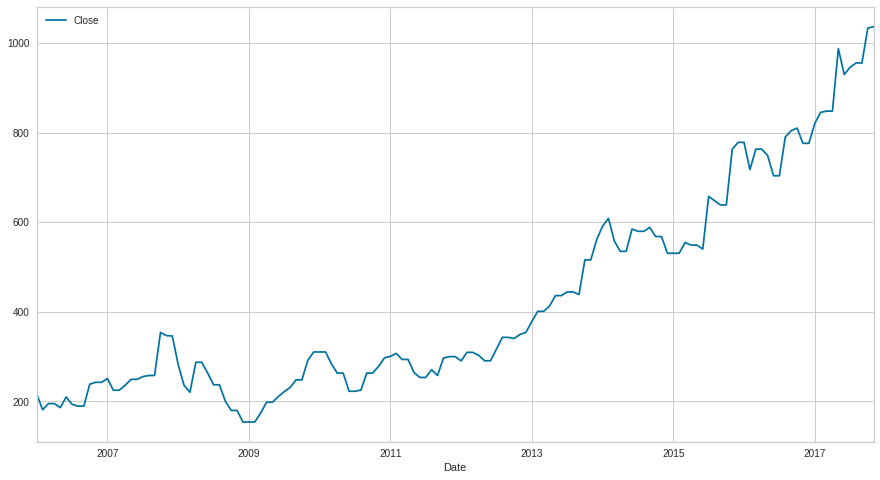

In [8]:
df.plot(figsize = (15,8))

### Plot dos gráficos de ACF e PACF

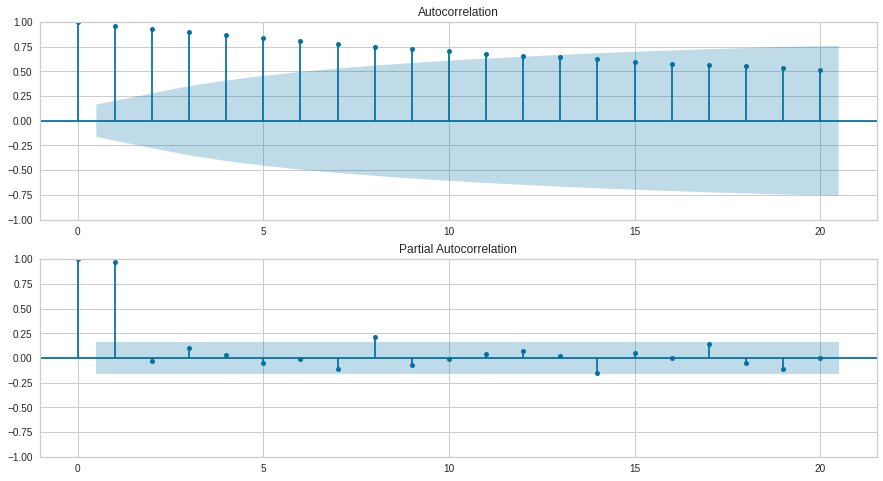

In [12]:
ppp = df
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(ppp, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ppp, lags=20, ax=ax[1])
plt.show()

### Plot da decomposição da série

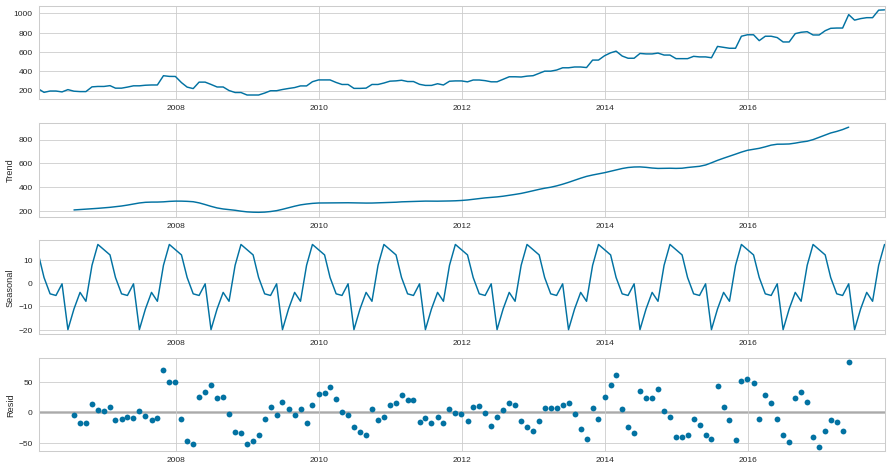

In [13]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':60})
result = seasonal_decompose(df, model='additive')
result.plot()
plt.show()

## Teste de Dickey-Fuller

Vamos realizar este teste para que comprovemos que não há estacionariedade na série. Este teste nos devolve o resultado da estatística de adf e o p-valor, onde as hipóteses do teste são:

H0: não há estacionariedade
 
H1: há estacionariedade

In [15]:
resultado = adfuller(df)
print('Estatística ADF: %f' % resultado[0])
print('p-valor: %f' % resultado[1])

Estatística ADF: 2.022453
p-valor: 0.998701


Como o p-valor foi maior que o nível de significância (0,05), nós não rejeitamos a hipótese nula. Portando, podemos afimar com 95% de confiança que a série não é estacionária.

## Escolha dos modelos para previsão com TSForecastingExperiment

A partir daqui utilizarei uma ferramenta do Pycaret chamada TSForecastingExperiment, que como o nome já diz, é um experimento criado para tentar facilitar a realização de previsão de séries temporais no Python.

Para acessar o site do projeto é só clicar [aqui](https://pycaret.readthedocs.io/en/latest/api/time_series.html#).

Obs: esta é minha primeira vez utilizando esta ferramenta, portanto, desculpe-me se eu tiver cometido algum erro.

### Configurando o setup

In [16]:
exp = TSForecastingExperiment()
exp.setup(data=df, fh=12, session_id=42)

INFO:logs:PyCaret TSForecastingExperiment
INFO:logs:Logging name: ts-default-name
INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
INFO:logs:version 3.0.0
INFO:logs:Initializing setup()
INFO:logs:self.USI: a872
INFO:logs:self.variable_keys: {'approach_type', 'n_jobs_param', 'html_param', 'y_transformed', 'master_model_container', 'seed', '_available_plots', 'fold_groups_param_full', 'memory', 'fold_generator', 'X_train', 'display_container', 'y_test_transformed', 'fold_param', 'experiment__', 'seasonality_present', 'exp_name_log', 'X_transformed', 'y_test', 'variable_keys', '_all_models_internal', 'y', 'exogenous_present', 'X_train_transformed', 'y_train_transformed', 'X_test', 'X_test_transformed', '_all_models', 'data', 'idx', 'pipeline', 'strictly_positive', 'y_train', 'gpu_param', 'logging_param', 'seasonal_period', 'primary_sp_to_use', '_all_metrics', 'enforce_exogenous', 'enforce_pi', 'exp_id', 'USI', '_gpu_n_jobs_param', 'index_type', '_ml_usecase', 'fh', 'X', 'all_sp_values', 'log_p

,Description,Value
0,session_id,42
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Data shape,"(143, 1)"
5,Train data shape,"(131, 1)"
6,Test data shape,"(12, 1)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


INFO:logs:setup() successfully completed in 0.71s...............


### Gráfico de treino e teste

Estou plotanto esse gráfico para que observemos onde exatamente será dividido o conjunto de dados em treino e teste (12 meses).

In [17]:
exp.plot_model(plot="train_test_split")

INFO:logs:Visual Rendered Successfully


### Modelos disponíveis

In [18]:
exp.models()

INFO:logs:gpu_param set to False


,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


### Escolha dos melhores modelos

Nesta parte irei selecionar os 4 melhores modelos para os nossos dados.

In [19]:
top4 = exp.compare_models(n_select = 4)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
auto_arima,Auto ARIMA,47.3114,55.7518,0.0759,0.0775,0.7075,0.6442,-2.4879,1.2367
naive,Naive Forecaster,47.2103,56.5507,0.0748,0.0781,0.7055,0.6522,-2.3538,1.1567
ets,ETS,51.4037,59.4021,0.0818,0.0858,0.7733,0.6914,-3.8033,0.1333
exp_smooth,Exponential Smoothing,51.824,59.8351,0.0824,0.0865,0.7797,0.6965,-3.8767,0.1400
arima,ARIMA,55.4345,62.4153,0.0867,0.0867,0.8115,0.7096,-1.9986,0.2467
theta,Theta Forecaster,57.3148,69.1719,0.0908,0.0976,0.8651,0.8044,-5.3422,0.0567
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasona...,58.6988,68.7644,0.0926,0.0987,0.8856,0.799,-5.1271,0.0600
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,72.8367,81.0488,0.1065,0.1137,1.0635,0.9202,-5.8933,0.0400
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,72.2332,78.1723,0.1082,0.1138,1.0633,0.8936,-5.3985,0.1400
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,74.1163,80.1052,0.1107,0.1166,1.0893,0.9146,-5.7248,1.0167


INFO:logs:master_model_container: 27
INFO:logs:display_container: 2
INFO:logs:[AutoARIMA(random_state=42, sp=12, suppress_warnings=True), NaiveForecaster(), AutoETS(seasonal='mul', sp=12, trend='add'), ExponentialSmoothing(seasonal='mul', sp=12, trend='add')]
INFO:logs:compare_models() successfully completed......................................


In [20]:
top4

[AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 NaiveForecaster(),
 AutoETS(seasonal='mul', sp=12, trend='add'),
 ExponentialSmoothing(seasonal='mul', sp=12, trend='add')]

## Criação dos modelos

Aqui eu irei criar os modelos que se sairam melhor e plotarei o gráfico que mostra o resultado do treino comparado com a série real.

### Modelo Auto Arima

In [21]:
arima = exp.create_model('auto_arima')
exp.plot_model(estimator = arima, plot = 'forecast', data_kwargs = {'fh' : 12})

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,55.5167,59.3919,0.0959,0.1014,0.9026,0.7445,-6.9214
1,2014-11,51.9562,61.2521,0.0846,0.0858,0.7276,0.6695,0.2491
2,2015-11,34.4613,46.6113,0.0472,0.0452,0.4924,0.5186,-0.7913
Mean,NaT,47.3114,55.7518,0.0759,0.0775,0.7075,0.6442,-2.4879
SD,NaT,9.2019,6.5077,0.0208,0.0237,0.1681,0.0940,3.1636


INFO:logs:master_model_container: 28
INFO:logs:display_container: 3
INFO:logs:AutoARIMA(random_state=42, sp=12, suppress_warnings=True)
INFO:logs:create_model() successfully completed......................................


INFO:logs:Visual Rendered Successfully


### Modelo Naive

In [22]:
naive = exp.create_model('naive')

exp.plot_model(estimator = naive, plot = 'forecast', data_kwargs = {'fh' : 12})

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,55.5167,59.3919,0.0959,0.1014,0.9026,0.7445,-6.9214
1,2014-11,58.0325,75.3959,0.0910,0.0958,0.8127,0.8241,-0.1377
2,2015-11,28.0817,34.8643,0.0375,0.0371,0.4012,0.3879,-0.0022
Mean,NaT,47.2103,56.5507,0.0748,0.0781,0.7055,0.6522,-2.3538
SD,NaT,13.5649,16.6685,0.0264,0.0291,0.2183,0.1897,3.2303


INFO:logs:master_model_container: 29
INFO:logs:display_container: 5
INFO:logs:NaiveForecaster()
INFO:logs:create_model() successfully completed......................................


INFO:logs:Visual Rendered Successfully


### Modelo ETS

In [23]:
ets = exp.create_model('ets')

exp.plot_model(estimator = ets, plot = 'forecast', data_kwargs = {'fh' : 12})

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,66.8101,74.3675,0.1156,0.1244,1.0862,0.9323,-11.4198
1,2014-11,53.5665,67.8222,0.0854,0.0882,0.7502,0.7413,0.0794
2,2015-11,33.8345,36.0165,0.0444,0.0447,0.4834,0.4007,-0.0695
Mean,NaT,51.4037,59.4021,0.0818,0.0858,0.7733,0.6914,-3.8033
SD,NaT,13.5488,16.7506,0.0292,0.0326,0.2466,0.2199,5.3860


INFO:logs:master_model_container: 30
INFO:logs:display_container: 7
INFO:logs:AutoETS(seasonal='mul', sp=12, trend='add')
INFO:logs:create_model() successfully completed......................................


INFO:logs:Visual Rendered Successfully


### Modelo de Suavização Exponencial

In [24]:
smooth = exp.create_model('exp_smooth')

exp.plot_model(estimator = smooth, plot = 'forecast', data_kwargs = {'fh' : 12})

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,67.4912,74.9363,0.1168,0.1257,1.0973,0.9394,-11.6105
1,2014-11,53.7422,68.2568,0.0856,0.0885,0.7527,0.7461,0.0676
2,2015-11,34.2385,36.3124,0.0449,0.0452,0.4892,0.4040,-0.0872
Mean,NaT,51.8240,59.8351,0.0824,0.0865,0.7797,0.6965,-3.8767
SD,NaT,13.6430,16.8552,0.0294,0.0329,0.2490,0.2214,5.4690


INFO:logs:master_model_container: 31
INFO:logs:display_container: 9
INFO:logs:ExponentialSmoothing(seasonal='mul', sp=12, trend='add')
INFO:logs:create_model() successfully completed......................................


INFO:logs:Visual Rendered Successfully


## Tuning dos modelos

O tuning dos modelos com essa ferramenta se dá em duas partes:

- Tunar os 4 modelos separadamente ajustando os hiperparâmetros para um melhor desempenho dos modelos.
- Fazer um 'blend' é meio que juntar os melhores modelos já tunados para fazer uma previsão conjunta.

### Tune

In [25]:
for model in range(4):
    exp.tune_model(top4[model])

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,66.5435,75.9070,0.1149,0.1240,1.0819,0.9516,-11.9393
1,2014-11,43.1748,57.9425,0.0682,0.0715,0.6047,0.6333,0.3281
2,2015-11,41.0189,54.8060,0.0535,0.0525,0.5861,0.6098,-1.4765
Mean,NaT,50.2457,62.8852,0.0789,0.0827,0.7575,0.7316,-4.3626
SD,NaT,11.5578,9.2964,0.0262,0.0302,0.2295,0.1559,5.4080


INFO:logs:master_model_container: 43
INFO:logs:display_container: 14
INFO:logs:ExponentialSmoothing(seasonal='mul', sp=12, trend='mul', use_boxcox=True)
INFO:logs:tune_model() succesfully completed......................................


### Blend

In [26]:
blender = exp.blend_models(top4)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2013-11,61.3337,66.2626,0.1060,0.1129,0.9972,0.8307,-8.8602
1,2014-11,54.3244,67.2732,0.0866,0.0896,0.7608,0.7353,0.0943
2,2015-11,27.0704,32.0217,0.0362,0.0357,0.3868,0.3563,0.1546
Mean,NaT,47.5762,55.1858,0.0763,0.0794,0.7149,0.6408,-2.8704
SD,NaT,14.7794,16.3847,0.0294,0.0323,0.2513,0.2049,4.2354


INFO:logs:master_model_container: 44
INFO:logs:display_container: 15
INFO:logs:_EnsembleForecasterWithVoting(forecasters=[('Auto ARIMA',
                                            AutoARIMA(random_state=42, sp=12,
                                                      suppress_warnings=True)),
                                           ('Naive Forecaster',
                                            NaiveForecaster()),
                                           ('ETS',
                                            AutoETS(seasonal='mul', sp=12,
                                                    trend='add')),
                                           ('Exponential Smoothing',
                                            ExponentialSmoothing(seasonal='mul',
                                                                 sp=12,
                                                                 trend='add'))],
                              n_jobs=-1)
INFO:logs:blend_models() succesfully com

## Finalizando o modelo

In [27]:
modelo_final = exp.finalize_model(blender)
prev = exp.predict_model(modelo_final)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(self=<pycaret.time_series.forecasting.oop.TSForecastingExperiment object at 0x7f9c5e7b1e50>, estimator=_EnsembleForecasterWithVoting(forecasters=[('Auto ARIMA',
                                            AutoARIMA(random_state=42, sp=12,
                                                      suppress_warnings=True)),
                                           ('Naive Forecaster',
                                            NaiveForecaster()),
                                           ('ETS',
                                            AutoETS(seasonal='mul', sp=12,
                                                    trend='add')),
                                           ('Exponential Smoothing',
                                            ExponentialSmoothing(seasonal='mul',
                                                                 sp=12,
                                                                 trend='a

### Plot da predição do nosso modelo

In [28]:
exp.plot_model(estimator = blender, plot = 'forecast', data_kwargs = {'fh' : 12})

INFO:logs:Visual Rendered Successfully


Aqui podemos ver que o modelo não conseguiu prever tão bem o que aconteceria entre janeiro e novembro de 2017.

### Plot da previsão de 12 mêses do nosso modelo

In [29]:
exp.plot_model(modelo_final)

INFO:logs:Visual Rendered Successfully


## Conclusão

Após realizarmos todos os procedimentos em busca do melhor modelo ajustado a nossos dados, concluímos que o modelo final obtido não foi tão eficiente, pois não conseguiu se sair bem na predição feita.

Indico para estudos futuros um aprofundamento na teoria de séries temporais e nesta ferramenta, ou a busca de melhores ferramentas para análises mais completas e mais acuradas.